In [1]:
 #Import python packages
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

In [2]:
def Mop(Fwp, Fbp):
    '''
    Mop : Mass of phosphate in the oceans
    Fwp : Flux of phosphate into the oceans
    Pbp : flux of phosphate out of the oceans due to burial
    dt  : time interval
    y   : dummy variable to store results
    '''
    y = (Fwp - Fbp)
    return y

def Fwp(weatherability, ClimateWeatheringFactor):
    '''
    Flux of phosphate to the oceans (10^12 mol per ky)
    '''
    y = 30 * weatherability * ClimateWeatheringFactor
    return y

def Fbp(Mop, Mop_initial):
    '''Burial of phosphate
    Mop : mass of phosphatein the ocean
    Mop_initial : initial Mop set to 3e3 x 10e12 mol/myr
    '''
    y = 30 * (Mop / Mop_initial)
    return y

def Moc(Fworg, Fvolc, Fborg, Fwsil):
    y = (Fworg + Fvolc - Fborg - Fwsil)
    return y

def Fworg(weatherability, ClimateWeatheringFactor):
    y = 1e4 * weatherability * ClimateWeatheringFactor
    return y

def Fborg(Fbp, CtoP=333):
    y = Fbp * CtoP
    return y

def Fwsil(weatherability, ClimateWeatheringFactor):
    y = 6e3 * weatherability * ClimateWeatheringFactor
    return y

def Ro(ro, rb, rr, Fwsr, Fvolc, fhyd, Mosr):
    y = (((1+ro)/(1+rb)) * (rr-ro) * Fwsr + ((1+ro)/(1+rb)) * (rb-ro) * Fvolc * fhyd) / (Mosr)
    return y

def Rr(time, weatherability):
    if time < 2e4:
        y = 0.7106 - time * 1e-8
    else:
        y = (0.7104 + (weatherability - 1) * 0.7043) / (weatherability)
    return y

def Fwsr(weatherability, climateweatheringfactor):
    y = 30 * weatherability * climateweatheringfactor
    return y

def pCO2(Moc, Moc_0=1.61e7, pCO2_0=5000):
    y = (Moc / Moc_0)**2 * pCO2_0
    return y

def CWF(pCO2, pCO2_0=5000):
    y = (pCO2/pCO2_0)**0.3
    return y

In [3]:
dt = 1

# time
time_min = 0
time_max = 40000
time = np.arange(time_min, time_max, dt)

# array size
t = len(time)

age = 484 - time/1e3

#set time and rate of weatherability change
rise_start = np.where(np.round(age)==462)[0][0]     #statement looks up timestep closest to specified age, e.g. 463 Ma
rise_stop = np.where(np.round(age)==455)[0][0]      #original Young model has rise start at 463, stop 459, fall 447, stop 443
fall_start = np.where(np.round(age)==453)[0][0]

In [4]:
# Weatherability
W = np.ones(t)
W[rise_start:rise_stop] = np.linspace(1.0, 1.25, (rise_stop-rise_start))
W[rise_stop:] = 1.25

# pCO2
pco2= np.ones(t) # array for pCO2
pco2_0 = 5000     # initial value of pCO2
pco2[0] = pco2_0

# Climate Weathering Factor (CWP)
cwf = np.ones(t)
cwf[0] = CWF(pco2[0])

In [5]:
# load sea level data
ordosealevel = np.load("../Data/OrdoSeaLevel.npz")['SeaLevel']
ordoseaage = np.load("../Data/OrdoSeaLevel.npz")['age']

# resample data to fit our modeling array
from scipy import interpolate
f = interpolate.interp1d(ordoseaage, ordosealevel)
sealevel = f(age)

# normalize sea level relative to mean
sl_norm = sealevel / sealevel.mean()

# Initialize Fvolc; also tuning of volc flux
fvolc = np.ones(t)
fvolc = sl_norm * 6000 # initial value = 6000 (Kump and Arthur, 1999)

In [6]:
#Initialize arrays for diff.eq #1
mop = np.ones(t)  # array for Mop
mop_0 = 3e3       # initial value of Mop
mop[0] = mop_0    # assign initial value into array

fwp = Fwp(W, cwf)     # initiate array for phosphorus flux
fbp = Fbp(mop, mop_0) # initiate array for phosphorus burial

# Initialize arrays for diff.eq #2
moc = np.ones(t)  # array for Moc
moc_0 = 1.61e7    # initial value of Moc
moc[0] = moc_0    # assign initial value into array

fworg = Fworg(W, cwf)
fborg = Fborg(fbp)
fwsil = Fwsil(W, cwf)

In [7]:
for i in range(t-1):

    fworg[i+1] = Fworg(W[i], cwf[i])
    fborg[i+1] = Fborg(fbp[i])
    fwsil[i+1] = Fwsil(W[i], cwf[i])
    moc[i+1] = moc[i] + dt*Moc(fworg[i], fvolc[i], fborg[i], fwsil[i])

    pco2[i+1] = pCO2(moc[i], moc_0, pco2_0)
    cwf[i+1] = CWF(pco2[i])

    fwp[i+1] = Fwp(W[i], cwf[i])
    fbp[i+1] = Fbp(mop[i], mop_0)
    mop[i+1] = mop[i] + dt*Mop(fwp[i],fbp[i])

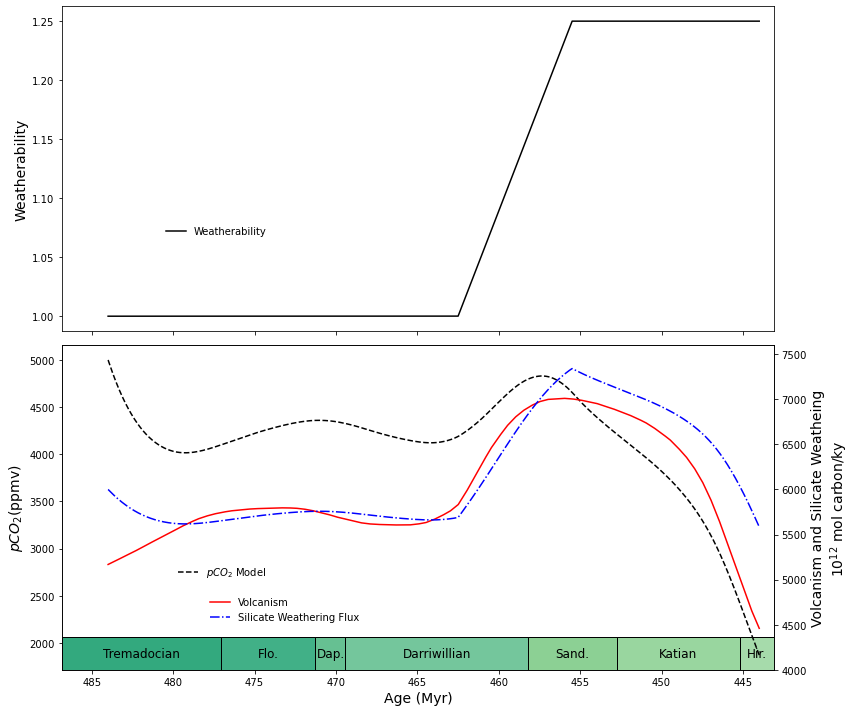

In [8]:
# Plotting
fig, (ax1, ax3) = plt.subplots(2, 1, sharex=True, figsize=(12,10))

ax1.plot(age, W, 'k-', label='Weatherability')
ax1.legend(bbox_to_anchor=(0.3, 0.35), edgecolor='None')
ax1.set_ylabel('Weatherability', fontsize=14)


ax3.plot(age, pco2, 'k--', label= '$pCO_2$ Model')
ax3.set_ylabel('$pCO_2$(ppmv)', fontsize=14)
ax3.legend(bbox_to_anchor=(0.3, 0.35), edgecolor='None')

ax4 = ax3.twinx()
ax4.plot(age, fvolc, 'r-', label='Volcanism')
ax4.plot(age, fwsil, 'b-.', label='Silicate Weathering Flux')
ax4.set_ylabel('Volcanism and Silicate Weatheing\n$10^{12}$ mol carbon/ky', fontsize=14)
ax4.legend(bbox_to_anchor=(0.43, 0.25), edgecolor='None')
ax4.set_ylim(4000, 7600)


ax3.set_xlabel('Age (Myr)', fontsize=14)
ax3.set_xlim(486.85, 443.07)

# Load Ordovician GTS2020
chronoDf = pd.read_excel('../Data/OrdoGTS2020.xlsx')
trans = ax3.get_xaxis_transform()
for ind in chronoDf.index:
    ax3.add_patch(Rectangle(xy=[chronoDf['top'][ind], 0],
                           height=0.1,
                           width=chronoDf['h'][ind], transform = trans,
                           ec = 'black', fc = chronoDf['color'][ind]))
    ax3.text(chronoDf['top'][ind]+0.5*chronoDf['h'][ind], 0.05, str(chronoDf['mix'][ind]), rotation=0,
            horizontalalignment='center',
            verticalalignment='center', transform = trans, fontsize = 12)

plt.tight_layout()

In [9]:
# Sr cycle
def Ro(ro, rb, rr, Fwsr, Fvolc, fhyd, Mosr):
    y = (((1+ro)/(1+rb)) * (rr-ro) * Fwsr + ((1+ro)/(1+rb)) * (rb-ro) * Fvolc * fhyd) / (Mosr)
    return y

def Rr(time, weatherability):
    if time < 2e4:
        y = 0.7106 - time * 1e-8
    else:
        y = (0.7104 + (weatherability - 1) * 0.7043) / (weatherability)
    return y

def Fwsr(weatherability, climateweatheringfactor):
    y = 30 * weatherability * climateweatheringfactor
    return y

# Initialize Mosr
mosr = np.ones(t) * 19e4

# Initialize arrays for diff.eq #3
ro = np.ones(t)
ro_0 = 0.7091
ro[0] = ro_0

rb = np.ones(t) * 0.7037
fhyd = np.ones(t) * 1.75e-3

rr = np.ones(t)
rr[0] = Rr(time[0], W[0])

fwsr = np.ones(t)
fwsr[0] = Fwsr(W[0], cwf[0])

In [10]:
# Model implementation
for i in range(t-1):

    fworg[i+1] = Fworg(W[i], cwf[i])
    fborg[i+1] = Fborg(fbp[i])
    fwsil[i+1] = Fwsil(W[i], cwf[i])
    moc[i+1] = moc[i] + dt*Moc(fworg[i], fvolc[i], fborg[i], fwsil[i])

    pco2[i+1] = pCO2(moc[i], moc_0, pco2_0)
    cwf[i+1] = CWF(pco2[i])

    fwp[i+1] = Fwp(W[i], cwf[i])
    fbp[i+1] = Fbp(mop[i], mop_0)
    mop[i+1] = mop[i] + dt*Mop(fwp[i],fbp[i])

    rr[i+1] = Rr(time[i], W[i])
    fwsr[i+1] = Fwsr(W[i], cwf[i])
    ro[i+1] = ro[i] + dt*Ro(ro[i], rb[i], rr[i], fwsr[i], fvolc[i], fhyd[i], mosr[i])

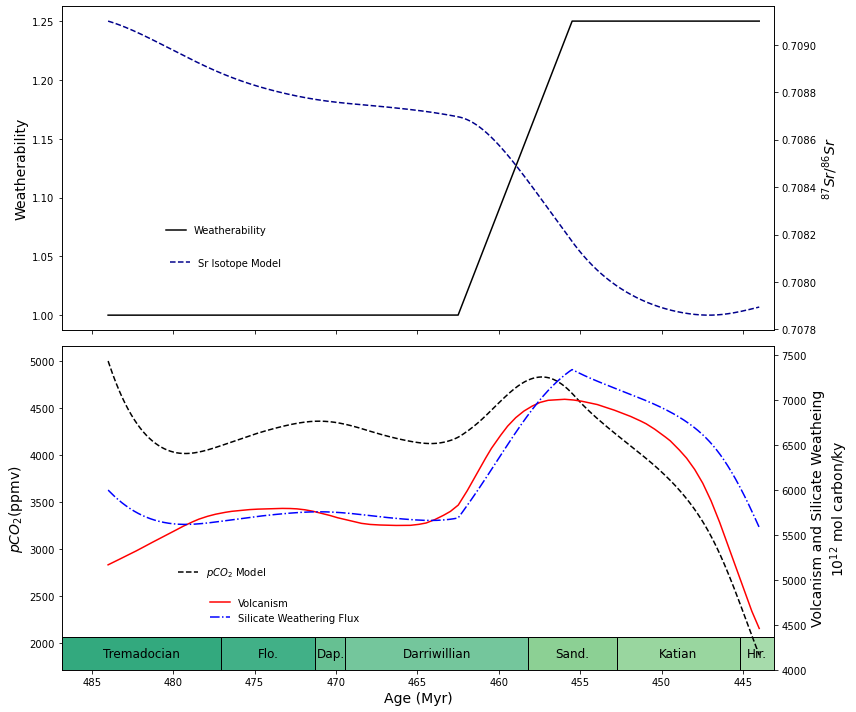

In [11]:
# Plotting
fig, (ax1, ax3) = plt.subplots(2, 1, sharex=True, figsize=(12,10))

ax1.plot(age, W, 'k-', label='Weatherability')
ax1.legend(bbox_to_anchor=(0.3, 0.35), edgecolor='None')
ax1.set_ylabel('Weatherability', fontsize=14)

ax2 = ax1.twinx()
ax2.plot(age, ro, c='darkblue', ls='--',label= 'Sr Isotope Model')
ax2.set_ylabel('$^{87}Sr/^{86}Sr$', fontsize=14)
ax2.legend(bbox_to_anchor=(0.32, 0.25), edgecolor='None')

ax3.plot(age, pco2, 'k--', label= '$pCO_2$ Model')
ax3.set_ylabel('$pCO_2$(ppmv)', fontsize=14)
ax3.legend(bbox_to_anchor=(0.3, 0.35), edgecolor='None')

ax4 = ax3.twinx()
ax4.plot(age, fvolc, 'r-', label='Volcanism')
ax4.plot(age, fwsil, 'b-.', label='Silicate Weathering Flux')
ax4.set_ylabel('Volcanism and Silicate Weatheing\n$10^{12}$ mol carbon/ky', fontsize=14)
ax4.legend(bbox_to_anchor=(0.43, 0.25), edgecolor='None')
ax4.set_ylim(4000, 7600)


ax3.set_xlabel('Age (Myr)', fontsize=14)
ax3.set_xlim(486.85, 443.07)

# Load Ordovician GTS2020
chronoDf = pd.read_excel('../Data/OrdoGTS2020.xlsx')
trans = ax3.get_xaxis_transform()
for ind in chronoDf.index:
    ax3.add_patch(Rectangle(xy=[chronoDf['top'][ind], 0],
                           height=0.1,
                           width=chronoDf['h'][ind], transform = trans,
                           ec = 'black', fc = chronoDf['color'][ind]))
    ax3.text(chronoDf['top'][ind]+0.5*chronoDf['h'][ind], 0.05, str(chronoDf['mix'][ind]), rotation=0,
            horizontalalignment='center',
            verticalalignment='center', transform = trans, fontsize = 12)

plt.tight_layout()
plt.savefig("../Figures/degassing_CO2_Sr.png", dpi=300)

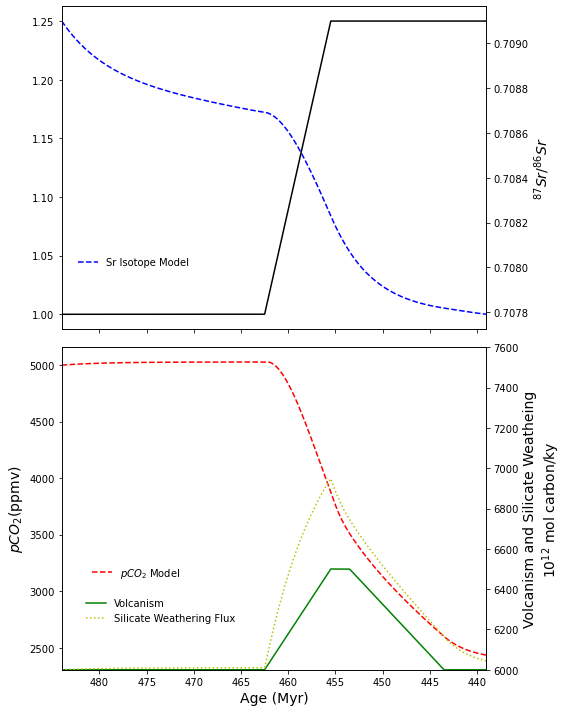

In [12]:
rr_new = rr
cwf_new = cwf
age_new = age
fvolc_new = fvolc
# time
time_min = 0
time_max = 45000
time = np.arange(time_min, time_max, dt)

# array size
t = len(time)

age = 484 - time/1e3

#set time and rate of weatherability change
rise_start = np.where(np.round(age)==462)[0][0]     #statement looks up timestep closest to specified age, e.g. 463 Ma
rise_stop = np.where(np.round(age)==455)[0][0]      #original Young model has rise start at 463, stop 459, fall 447, stop 443
fall_start = np.where(np.round(age)==453)[0][0]
fall_stop = np.where(np.round(age)==443)[0][0]

# Weatherability
W = np.ones(t)
W[rise_start:rise_stop] = np.linspace(1.0, 1.25, (rise_stop-rise_start))
W[rise_stop:] = 1.25

# pCO2
pco2= np.ones(t) # array for pCO2
pco2_0 = 5000     # initial value of pCO2
pco2[0] = pco2_0

# Climate Weathering Factor (CWP)
cwf = np.ones(t)
cwf[0] = CWF(pco2[0])

# Initialize Fvolc; also tuning of volc flux
fvolc = np.ones(t) * 6000 # initial value = 6000 (Kump and Arthur, 1999)

base_volc = 6000    #baseline volcanic flux [1e12 mol C/yr]
peak_volc = 6500    #peak "..."
Vlc_rise_stop = rise_stop + 0   #make the rise in fvolc stop earlier than rise in fsilw stops
peak_fall = peak_volc - 0         #make fvolc fall slowly after reaching its peak
fvolc[rise_start:Vlc_rise_stop] = np.linspace(base_volc, peak_volc, (Vlc_rise_stop-rise_start))
fvolc[Vlc_rise_stop:fall_start] = np.linspace(peak_volc, peak_fall, (fall_start-Vlc_rise_stop)) #fvolc[Vlc_rise_stop:fall_start] + (peak_volc - base_volc) - peak_fall   #np.linspace[peak_volc, peak_volc - base_volc, Vlc_rise_stop - fall_start]
fvolc[fall_start:fall_stop] = np.linspace(peak_fall, base_volc, (fall_stop-fall_start))


# Initialize Mosr
mosr = np.ones(t) * 19e4

#Initialize arrays for diff.eq #1
mop = np.ones(t)  # array for Mop
mop_0 = 3e3       # initial value of Mop
mop[0] = mop_0    # assign initial value into array

fwp = Fwp(W, cwf)     # initiate array for phosphorus flux
fbp = Fbp(mop, mop_0) # initiate array for phosphorus burial

# Initialize arrays for diff.eq #2
moc = np.ones(t)  # array for Moc
moc_0 = 1.61e7    # initial value of Moc
moc[0] = moc_0    # assign initial value into array

fworg = Fworg(W, cwf)
fborg = Fborg(fbp)
fwsil = Fwsil(W, cwf)

# Initialize arrays for diff.eq #3
ro = np.ones(t)
ro_0 = 0.7091
ro[0] = ro_0

rb = np.ones(t) * 0.7037
fhyd = np.ones(t) * 1.75e-3

rr = np.ones(t)
rr[0] = Rr(time[0], W[0])

fwsr = np.ones(t)
fwsr[0] = Fwsr(W[0], cwf[0])

# Model implementation
for i in range(t-1):

    fworg[i+1] = Fworg(W[i], cwf[i])
    fborg[i+1] = Fborg(fbp[i])
    fwsil[i+1] = Fwsil(W[i], cwf[i])
    moc[i+1] = moc[i] + dt*Moc(fworg[i], fvolc[i], fborg[i], fwsil[i])

    pco2[i+1] = pCO2(moc[i], moc_0, pco2_0)
    cwf[i+1] = CWF(pco2[i])

    fwp[i+1] = Fwp(W[i], cwf[i])
    fbp[i+1] = Fbp(mop[i], mop_0)
    mop[i+1] = mop[i] + dt*Mop(fwp[i],fbp[i])

    rr[i+1] = Rr(time[i], W[i])
    fwsr[i+1] = Fwsr(W[i], cwf[i])
    ro[i+1] = ro[i] + dt*Ro(ro[i], rb[i], rr[i], fwsr[i], fvolc[i], fhyd[i], mosr[i])


# Plotting
fig, (ax1, ax3) = plt.subplots(2, 1, sharex=True, figsize=(8,10))

ax1.plot(age, W, 'k-', label='Weatherability')
ax2 = ax1.twinx()
ax2.plot(age, ro, 'b--', label= 'Sr Isotope Model')
ax2.set_ylabel('$^{87}Sr/^{86}Sr$', fontsize=14)
ax2.legend(bbox_to_anchor=(0.32, 0.25), edgecolor='None')

ax3.plot(age, pco2, 'r--', label= '$pCO_2$ Model')
ax3.set_ylabel('$pCO_2$(ppmv)', fontsize=14)
ax3.legend(bbox_to_anchor=(0.3, 0.35), edgecolor='None')

ax4 = ax3.twinx()
ax4.plot(age, fvolc, 'g-', label='Volcanism')
ax4.plot(age, fwsil, 'y:', label='Silicate Weathering Flux')
ax4.set_ylabel('Volcanism and Silicate Weatheing\n$10^{12}$ mol carbon/ky', fontsize=14)
ax4.legend(bbox_to_anchor=(0.43, 0.25), edgecolor='None')
ax4.set_ylim(6000, 7600)
ax3.set_xlabel('Age (Myr)', fontsize=14)
ax3.set_xlim(max(age), min(age))

plt.tight_layout()
plt.show()

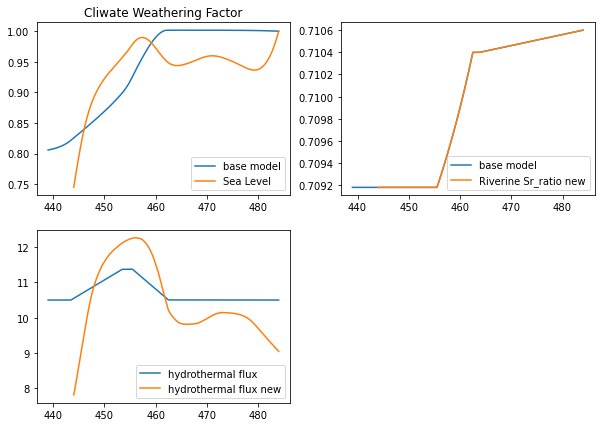

In [13]:
plt.figure(figsize=(10,7))
plt.subplot(221)
plt.plot(age, cwf, label='base model')
plt.plot(age_new, cwf_new, label='Sea Level')
plt.legend()
plt.title('Cliwate Weathering Factor')

plt.subplot(222)
plt.plot(age, rr, label='base model')
plt.plot(age_new, rr_new, label='Riverine Sr_ratio new')
plt.legend()

plt.subplot(223)
plt.plot(age, fvolc*fhyd, label='hydrothermal flux')
plt.plot(age_new, fvolc_new*1.75e-3, label='hydrothermal flux new')
plt.legend()

In [14]:
def runmod(x):
    dt = 1

    # time
    time_min = 0
    time_max = 40000
    time = np.arange(time_min, time_max, dt)

    # array size
    t = len(time)

    age = 484 - time/1e3

    #set time and rate of weatherability change
    rise_start = np.where(np.round(age)==462)[0][0]     #statement looks up timestep closest to specified age, e.g. 463 Ma
    rise_stop = np.where(np.round(age)==455)[0][0]      #original Young model has rise start at 463, stop 459, fall 447, stop 443
    fall_start = np.where(np.round(age)==453)[0][0]
    # Weatherability
    W = np.ones(t)
    W[rise_start:rise_stop] = np.linspace(1.0, x, (rise_stop-rise_start))
    W[rise_stop:] = x

    # pCO2
    pco2= np.ones(t) # array for pCO2
    pco2_0 = 5000     # initial value of pCO2
    pco2[0] = pco2_0

    # Climate Weathering Factor (CWP)
    cwf = np.ones(t)
    cwf[0] = CWF(pco2[0])
    
    # load sea level data
    ordosealevel = np.load("../Data/OrdoSeaLevel.npz")['SeaLevel']
    ordoseaage = np.load("../Data/OrdoSeaLevel.npz")['age']

    # resample data to fit our modeling array
    from scipy import interpolate
    f = interpolate.interp1d(ordoseaage, ordosealevel)
    sealevel = f(age)

    # normalize sea level relative to mean
    sl_norm = sealevel / sealevel.mean()
    
    Jh_sl = sl_norm * 2e10
    
    # Sr cycle
    def Ro(ro, rb, rr, Fwsr, Fvolc, fhyd, Mosr):
        y = (((1+ro)/(1+rb)) * (rr-ro) * Fwsr + ((1+ro)/(1+rb)) * (rb-ro) * Fvolc * fhyd) / (Mosr)
        return y

    def Rr(time, weatherability):
        if time < 2e4:
            y = 0.7106 - time * 1e-8
        else:
            y = (0.7104 + (weatherability - 1) * 0.7043) / (weatherability)
        return y

    def Fwsr(weatherability, climateweatheringfactor):
        y = 30 * weatherability * climateweatheringfactor
        return y



    # Initialize Fvolc; also tuning of volc flux
    fvolc = np.ones(t)
    fvolc = sl_norm * 6000 # initial value = 6000 (Kump and Arthur, 1999)
    
    #Initialize arrays for diff.eq #1
    mop = np.ones(t)  # array for Mop
    mop_0 = 3e3       # initial value of Mop
    mop[0] = mop_0    # assign initial value into array

    fwp = Fwp(W, cwf)     # initiate array for phosphorus flux
    fbp = Fbp(mop, mop_0) # initiate array for phosphorus burial

    # Initialize arrays for diff.eq #2
    moc = np.ones(t)  # array for Moc
    moc_0 = 1.61e7    # initial value of Moc
    moc[0] = moc_0    # assign initial value into array

    fworg = Fworg(W, cwf)
    fborg = Fborg(fbp)
    fwsil = Fwsil(W, cwf)
    
    # Initialize Mosr
    mosr = np.ones(t) * 19e4

    # Initialize arrays for diff.eq #3
    ro = np.ones(t)
    ro_0 = 0.7091
    ro[0] = ro_0

    rb = np.ones(t) * 0.7037
    fhyd = np.ones(t) * 1.75e-3

    rr = np.ones(t) * 0.7106
    rr[0] = Rr(time[0], W[0])

    fwsr = np.ones(t)
    fwsr[0] = Fwsr(W[0], cwf[0])
    
    # Model implementation
    for i in range(t-1):

        fworg[i+1] = Fworg(W[i], cwf[i])
        fborg[i+1] = Fborg(fbp[i])
        fwsil[i+1] = Fwsil(W[i], cwf[i])
        moc[i+1] = moc[i] + dt*Moc(fworg[i], fvolc[i], fborg[i], fwsil[i])

        pco2[i+1] = pCO2(moc[i], moc_0, pco2_0)
        cwf[i+1] = CWF(pco2[i])

        fwp[i+1] = Fwp(W[i], cwf[i])
        fbp[i+1] = Fbp(mop[i], mop_0)
        mop[i+1] = mop[i] + dt*Mop(fwp[i],fbp[i])

        rr[i+1] = Rr(time[i], W[i])
        fwsr[i+1] = Fwsr(W[i], cwf[i])
        ro[i+1] = ro[i] + dt*Ro(ro[i], rb[i], rr[i], fwsr[i], fvolc[i], fhyd[i], mosr[i])
    
    results = {'age': age,
               'W': W,
              'fwsil' : fwsil,
              'pco2': pco2,
               'fvolc':fvolc,
              'ro': ro}
    return results     

In [15]:
%%time
res = {}
ns = 10
weath = np.linspace(1, 2, ns)
for k in range(len(weath)):
    xx = str(int(k))
    res[xx] = runmod(weath[k])

Wall time: 11.2 s


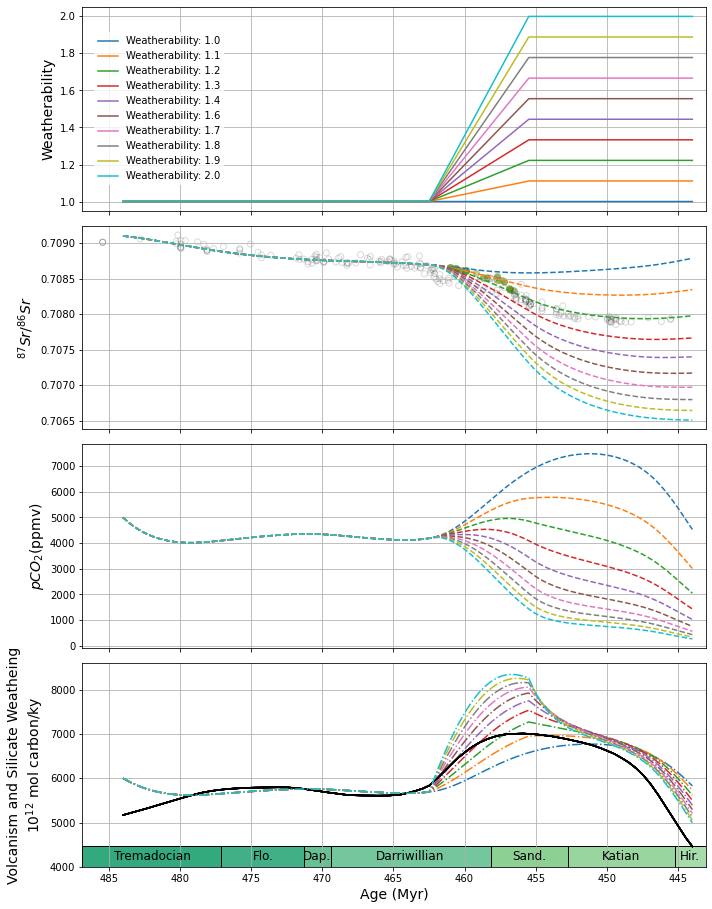

In [18]:
# Plotting
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(10,13))

SrOrdo = pd.read_csv('../Data/Arbuckle_Sr.csv')
SrOrdo_2014 = pd.read_csv('../Data/OrdoSr20.csv')

for key in res:
    ax1.plot(res[key]['age'], res[key]['W'], '-', label='Weatherability: '+str(round(res[key]['W'][-1],1)))
    ax2.plot(res[key]['age'], res[key]['ro'], ls='--',label= 'Sr Isotope Model'+key)
    ax3.plot(res[key]['age'], res[key]['pco2'], '--', label= '$pCO_2$ Model'+key)
    ax4.plot(res[key]['age'], res[key]['fvolc'], 'k-', label='Volcanism'+key)
    ax4.plot(res[key]['age'], res[key]['fwsil'], '-.', label='Silicate Weathering Flux'+key)
    
ax2.scatter(SrOrdo['age'], SrOrdo['sr'], c='olivedrab', label='Sr Conodont Data\n(This Study)', alpha=0.4)
ax2.scatter(SrOrdo_2014['Age20'], SrOrdo_2014['Sr'],
            ec='k', fc='None',
            label='Sr Conodont Data\n(Saltzman et al., 2014)',
            alpha=0.15)

ax1.set_ylabel('Weatherability', fontsize=14)
ax2.set_ylabel('$^{87}Sr/^{86}Sr$', fontsize=14)
ax3.set_ylabel('$pCO_2$(ppmv)', fontsize=14)
ax4.set_ylabel('Volcanism and Silicate Weatheing\n$10^{12}$ mol carbon/ky', fontsize=14)
ax4.set_ylim(4000, 8600)

for ax in (ax1,ax2, ax3, ax4):
    ax.grid(True)

ax4.set_xlabel('Age (Myr)', fontsize=14)
ax4.set_xlim(486.85, 443.07)

ax1.legend(loc='lower left', bbox_to_anchor=(0.01, 0.1), edgecolor='None')
# ax2.legend(loc='lower left', bbox_to_anchor=(1.1, 0.5), edgecolor='None')
# ax3.legend(loc='lower left', bbox_to_anchor=(1.1, 0.1), edgecolor='None')
# ax4.legend(loc='lower left', bbox_to_anchor=( 1.1, 0.1), edgecolor='None')

# Load Ordovician GTS2020
chronoDf = pd.read_excel('../Data/OrdoGTS2020.xlsx')
trans = ax4.get_xaxis_transform()
for ind in chronoDf.index:
    ax4.add_patch(Rectangle(xy=[chronoDf['top'][ind], 0],
                           height=0.1,
                           width=chronoDf['h'][ind], transform = trans,
                           ec = 'black', fc = chronoDf['color'][ind]))
    ax4.text(chronoDf['top'][ind]+0.5*chronoDf['h'][ind], 0.05, str(chronoDf['mix'][ind]), rotation=0,
            horizontalalignment='center',
            verticalalignment='center', transform = trans, fontsize = 12)

plt.savefig("../Figures/degassing_CO2_Sr_varyWeatherability.png", dpi=300)
plt.tight_layout()

In [19]:
def runmod2(x):
    dt = 1

    # time
    time_min = 0
    time_max = 40000
    time = np.arange(time_min, time_max, dt)

    # array size
    t = len(time)

    age = 484 - time/1e3

    #set time and rate of weatherability change
    rise_start = np.where(np.round(age)==462)[0][0]     #statement looks up timestep closest to specified age, e.g. 463 Ma
    rise_stop = np.where(np.round(age)==455)[0][0]      #original Young model has rise start at 463, stop 459, fall 447, stop 443
    rise_mid0 = np.where(np.round(age)==460)[0][0]
    rise_mid1 = np.where(np.round(age)==457)[0][0]
    fall_start = np.where(np.round(age)==453)[0][0]
    # Weatherability
    W = np.ones(t)
    y = 1.0 + abs(x-1)/2
    W[rise_start:rise_mid0] = np.linspace(1.0, y, (rise_mid0-rise_start))
    W[rise_mid0:rise_mid1] = y
    W[rise_mid1:rise_stop] = np.linspace(y, x, (rise_stop-rise_mid1))
    W[rise_stop:] = x

    # pCO2
    pco2= np.ones(t) # array for pCO2
    pco2_0 = 5000     # initial value of pCO2
    pco2[0] = pco2_0

    # Climate Weathering Factor (CWP)
    cwf = np.ones(t)
    cwf[0] = CWF(pco2[0])
    
    # load sea level data
    ordosealevel = np.load("../Data/OrdoSeaLevel.npz")['SeaLevel']
    ordoseaage = np.load("../Data/OrdoSeaLevel.npz")['age']

    # resample data to fit our modeling array
    from scipy import interpolate
    f = interpolate.interp1d(ordoseaage, ordosealevel)
    sealevel = f(age)

    # normalize sea level relative to mean
    sl_norm = sealevel / sealevel.mean()

    # Initialize Fvolc; also tuning of volc flux
    fvolc = np.ones(t)
    fvolc = sl_norm * 6000 # initial value = 6000 (Kump and Arthur, 1999)
    
    #Initialize arrays for diff.eq #1
    mop = np.ones(t)  # array for Mop
    mop_0 = 3e3       # initial value of Mop
    mop[0] = mop_0    # assign initial value into array

    fwp = Fwp(W, cwf)     # initiate array for phosphorus flux
    fbp = Fbp(mop, mop_0) # initiate array for phosphorus burial

    # Initialize arrays for diff.eq #2
    moc = np.ones(t)  # array for Moc
    moc_0 = 1.61e7    # initial value of Moc
    moc[0] = moc_0    # assign initial value into array

    fworg = Fworg(W, cwf)
    fborg = Fborg(fbp)
    fwsil = Fwsil(W, cwf)
    
    # Initialize Mosr
    mosr = np.ones(t) * 19e4

    # Initialize arrays for diff.eq #3
    ro = np.ones(t)
    ro_0 = 0.7091
    ro[0] = ro_0

    rb = np.ones(t) * 0.7037
    fhyd = np.ones(t) * 1.75e-3

    rr = np.ones(t)
    rr[0] = Rr(time[0], W[0])

    fwsr = np.ones(t)
    fwsr[0] = Fwsr(W[0], cwf[0])
    
    # Model implementation
    for i in range(t-1):

        fworg[i+1] = Fworg(W[i], cwf[i])
        fborg[i+1] = Fborg(fbp[i])
        fwsil[i+1] = Fwsil(W[i], cwf[i])
        moc[i+1] = moc[i] + dt*Moc(fworg[i], fvolc[i], fborg[i], fwsil[i])

        pco2[i+1] = pCO2(moc[i], moc_0, pco2_0)
        cwf[i+1] = CWF(pco2[i])

        fwp[i+1] = Fwp(W[i], cwf[i])
        fbp[i+1] = Fbp(mop[i], mop_0)
        mop[i+1] = mop[i] + dt*Mop(fwp[i],fbp[i])

        rr[i+1] = Rr(time[i], W[i])
        fwsr[i+1] = Fwsr(W[i], cwf[i])
        ro[i+1] = ro[i] + dt*Ro(ro[i], rb[i], rr[i], fwsr[i], fvolc[i], fhyd[i], mosr[i])
    
    results = {'age': age,
               'W': W,
              'fwsil' : fwsil,
              'pco2': pco2,
               'fvolc':fvolc,
              'ro': ro}
    return results 

In [20]:
res2 = runmod2(1.25)

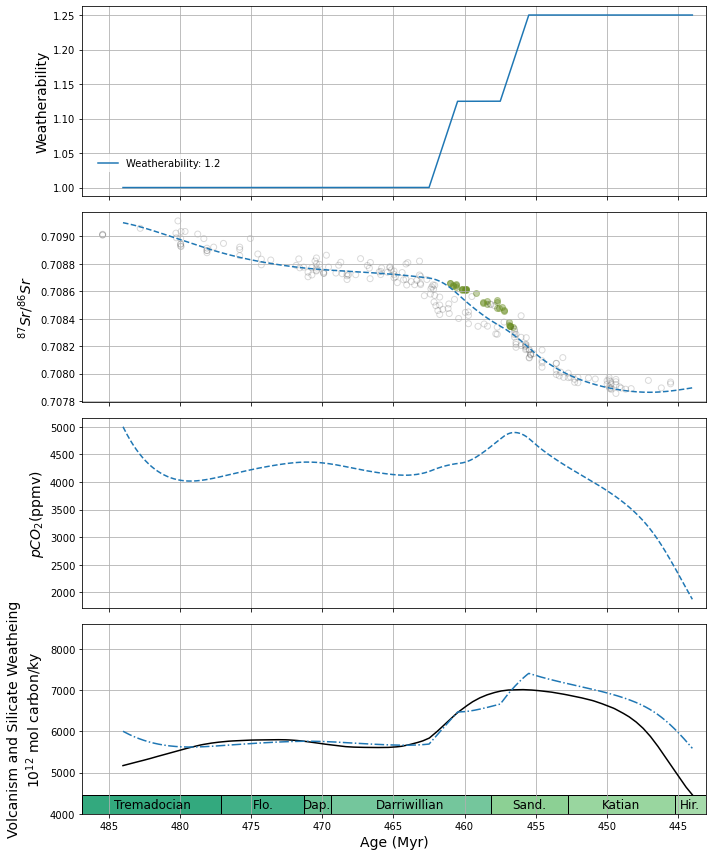

In [21]:
# Plotting
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, sharex=True, figsize=(10,12))

SrOrdo = pd.read_csv('../Data/Arbuckle_Sr.csv')
SrOrdo_2014 = pd.read_csv('../Data/OrdoSr20.csv')

ax1.plot(res2['age'], res2['W'], '-', label='Weatherability: '+str(round(res2['W'][-1],1)))
ax2.plot(res2['age'], res2['ro'], ls='--',label= 'Sr Isotope Model'+key)
ax3.plot(res2['age'], res2['pco2'], '--', label= '$pCO_2$ Model'+key)
ax4.plot(res2['age'], res2['fvolc'], 'k-', label='Volcanism'+key)
ax4.plot(res2['age'], res2['fwsil'], '-.', label='Silicate Weathering Flux'+key)
    
ax2.scatter(SrOrdo['age'], SrOrdo['sr'], c='olivedrab', label='Sr Conodont Data\n(This Study)', alpha=0.4)
ax2.scatter(SrOrdo_2014['Age20'], SrOrdo_2014['Sr'],
            ec='k', fc='None',
            label='Sr Conodont Data\n(Saltzman et al., 2014)',
            alpha=0.15)

ax1.set_ylabel('Weatherability', fontsize=14)
ax2.set_ylabel('$^{87}Sr/^{86}Sr$', fontsize=14)
ax3.set_ylabel('$pCO_2$(ppmv)', fontsize=14)
ax4.set_ylabel('Volcanism and Silicate Weatheing\n$10^{12}$ mol carbon/ky', fontsize=14)
ax4.set_ylim(4000, 8600)

for ax in (ax1,ax2, ax3, ax4):
    ax.grid(True)

ax4.set_xlabel('Age (Myr)', fontsize=14)
ax4.set_xlim(486.85, 443.07)

ax1.legend(loc='lower left', bbox_to_anchor=(0.01, 0.1), edgecolor='None')
# ax2.legend(loc='lower left', bbox_to_anchor=(1.1, 0.5), edgecolor='None')
# ax3.legend(loc='lower left', bbox_to_anchor=(1.1, 0.1), edgecolor='None')
# ax4.legend(loc='lower left', bbox_to_anchor=( 1.1, 0.1), edgecolor='None')

# Load Ordovician GTS2020
chronoDf = pd.read_excel('../Data/OrdoGTS2020.xlsx')
trans = ax4.get_xaxis_transform()
for ind in chronoDf.index:
    ax4.add_patch(Rectangle(xy=[chronoDf['top'][ind], 0],
                           height=0.1,
                           width=chronoDf['h'][ind], transform = trans,
                           ec = 'black', fc = chronoDf['color'][ind]))
    ax4.text(chronoDf['top'][ind]+0.5*chronoDf['h'][ind], 0.05, str(chronoDf['mix'][ind]), rotation=0,
            horizontalalignment='center',
            verticalalignment='center', transform = trans, fontsize = 12)

plt.savefig("../Figures/degassing_CO2_Sr_stepWeatherability.png", dpi=300)
plt.tight_layout()